## Train and Evaluate

In [2]:
import os
import keras
from keras import ops
import keras_hub
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from resize_img import process_images
import keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint

IMAGE_DIR = "../../dataset/images"
MASK_DIR = "../../dataset/masks"

2025-02-24 15:50:27.470276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 15:50:27.701611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740387027.792880   51553 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740387027.819352   51553 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 15:50:28.045913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
def load_images():
    images, masks = process_images(IMAGE_DIR, MASK_DIR, 512)
    
    if images is None or masks is None or images.size == 0 or masks.size == 0:
        print("Error loading images and masks.")
        raise ValueError("Error: No valid images or masks found!")
    
    images = images.astype("float32") / 255.0
    masks = masks.astype("float32") / 255.0
    indices = np.random.choice(len(images), 3, replace=False)
    plt.figure(figsize=(12, 6))
    for i, index in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[index])
        plt.title("Image")
        plt.axis("off")
        
        plt.subplot(2, 3, i + 4)
        plt.imshow(masks[index])
        plt.title("Mask")
        plt.axis("off")
    plt.show()
    return images, masks

In [4]:
def load_model():
    model = keras_hub.models.DeepLabV3ImageSegmenter.from_preset("deeplab_v3_plus_resnet50_pascalvoc")
    output = layers.Resizing(512, 512)(model.output)  
    model = keras.Model(inputs=model.input, outputs=output)
    return model

In [5]:
def prepare_dataset(images, masks, batch_size=2):
    """Create a TensorFlow dataset from NumPy arrays."""
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [6]:
def train_test_split(images, masks, test_size=0.05):
    """Split images and masks into training and testing sets."""
    n = len(images)
    indices = np.random.permutation(n)
    n_test = int(n * test_size)
    
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    train_images, train_masks = images[train_indices], masks[train_indices]
    test_images, test_masks = images[test_indices], masks[test_indices]
    print(f"Train samples: {len(train_images)}")
    print(f"Validation samples: {len(test_images)}")
    
    return train_images, train_masks, test_images, test_masks

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

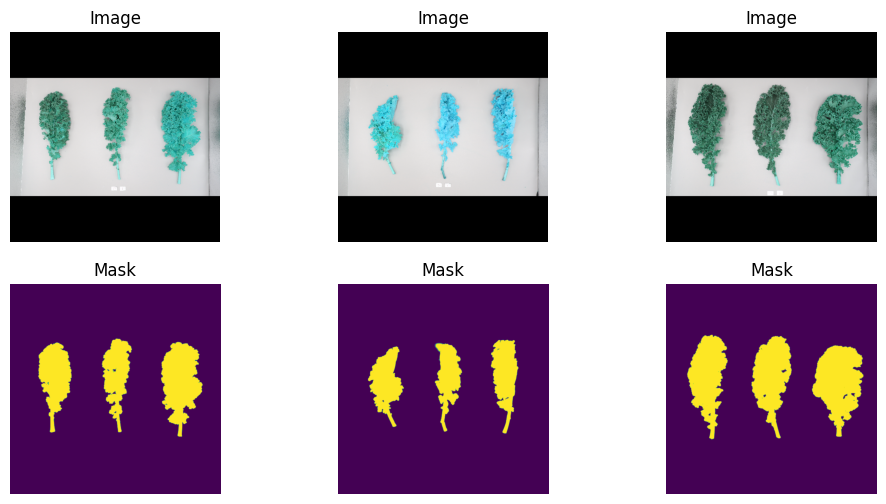

Train samples: 116
Validation samples: 6


I0000 00:00:1740387051.012459   51553 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/jemiezler/Dev/Kale-SeniorProject/backend/background-segmentation/bg-segment-venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 185 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50


/home/jemiezler/Dev/Kale-SeniorProject/backend/background-segmentation/bg-segment-venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


KeyboardInterrupt: 

In [7]:
images, masks = load_images()
train_images, train_masks, test_images, test_masks = train_test_split(images, masks, test_size=0.05)

train_dataset = prepare_dataset(train_images, train_masks, batch_size=2)
test_dataset = prepare_dataset(test_images, test_masks, batch_size=2)
model = load_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam')

checkpoint = ModelCheckpoint(
    filepath='../../models/best_model.keras',  
    monitor='val_loss',                    
    verbose=1,                             
    save_best_only=True,                   
    mode='min'                             
)
model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[checkpoint]
)
    

keras.saving.save_model(model, "../../models/deeplabv3_trained.keras")
print("Training complete!")


## Inference

✅ Model loaded successfully.


/home/jemiezler/Dev/Kale-SeniorProject/backend/background-segmentation/bg-segment-venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_225']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Predicted mask saved as: predicted_mask.png
✅ Visualization saved as 'output.png'


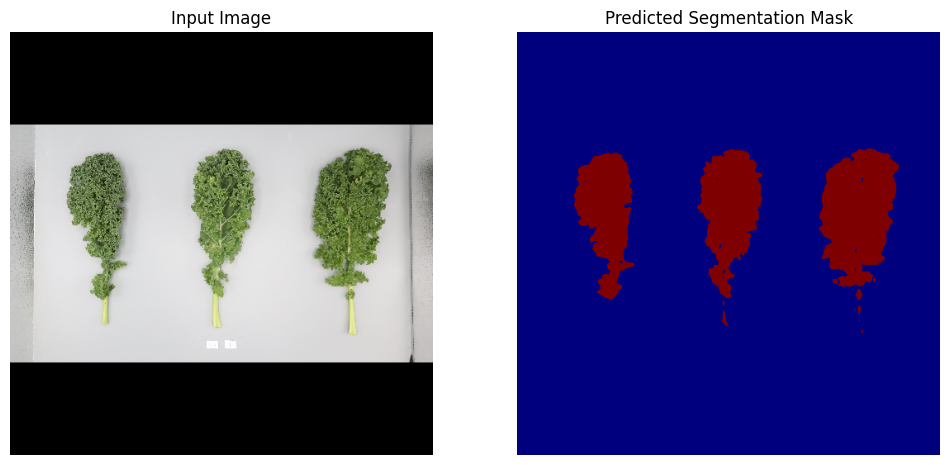

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from resize_img import resize_with_padding 


model = tf.keras.models.load_model('../../models/deeplabv3_trained.keras')
print("✅ Model loaded successfully.")


img_path = '../../dataset/images/8_5_1_2.jpg'


image = cv2.imread(img_path)
if image is None:
    raise ValueError(f"❌ Error: Image not found at {img_path}. Check the path.")


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


resized_image = resize_with_padding(image, 512)


input_image = resized_image.astype("float32") / 255.0


input_image = np.expand_dims(input_image, axis=0)


predictions = model.predict(input_image)


predicted_mask = np.argmax(predictions, axis=-1).squeeze()  


mask_output_path = "predicted_mask.png"
cv2.imwrite(mask_output_path, (predicted_mask * 255).astype(np.uint8))  
print(f"✅ Predicted mask saved as: {mask_output_path}")


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.imshow(resized_image)
plt.title("Input Image")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="jet")
plt.title("Predicted Segmentation Mask")
plt.axis("off")


plt.savefig("output.png")
print("✅ Visualization saved as 'output.png'")

plt.show()
